In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time

# Data

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, Compose

import os
import random
import datetime
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.dataset import CutOrPad, get_rgb

In [3]:
PASTIS24 = './data/PASTIS24/'
PASTIS9 = './data/PASTIS9/'

PATH = PASTIS24

In [4]:
files = os.listdir(PATH)
file = random.choice(files)

In [5]:
data = pd.read_pickle(PATH + file)

print(data.keys())
print('Image: ', data['img'].shape)
print('Labels: ', data['labels'].shape, data['labels'])
print('DOY: ', data['doy'].shape, data['doy'])

dict_keys(['img', 'labels', 'doy'])
Image:  (43, 10, 24, 24)
Labels:  (24, 24) [[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
 [3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
 [3. 3. 3. 0. 1. 1. 1

In [6]:
class PASTIS(Dataset):
    def __init__(self, pastis_path):
        self.pastis_path = pastis_path

        self.file_names = os.listdir(self.pastis_path)[:500]

        random.shuffle(self.file_names)

        self.to_cutorpad = CutOrPad()
        # self.to_tiledates = TileDates(24, 24)
        # self.to_unkmask = UnkMask(unk_class=19, ground_truth_target='labels'))



    def __len__(self):
        return len(self.file_names)


    def add_date_channel(self, img, doy):
        img = torch.cat((img, doy), dim=1)
        return img


    def normalize(self, img):
        C = img.shape[1]
        mean = img.mean(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)
        std = img.std(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)

        img = (img - mean) / std

        return img


    def __getitem__(self, idx):
        data = pd.read_pickle(os.path.join(self.pastis_path, self.file_names[idx]))

        data['img'] = data['img'].astype('float32')
        data['img'] = torch.tensor(data['img'])
        data['img'] = self.normalize(data['img'])
        T, C, H, W = data['img'].shape

        data['labels'] = data['labels'].astype('long')
        data['labels'] = torch.tensor(data['labels'])
        # data['labels'] = F.one_hot(data['labels'].long(), num_classes=20)

        data['doy'] = data['doy'].astype('float32')
        data['doy'] = torch.tensor(data['doy'])
        data['doy'] = data['doy'].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        data['doy'] = data['doy'].repeat(1, 1, H, W)

        data['img'] = self.add_date_channel(data['img'], data['doy']) # add DOY to the last channel
        del data['doy'] # Delete DOY

        data = self.to_cutorpad(data) # Pad to Max Sequence Length
        del data['seq_lengths'] # Delete Sequence Length


        return data['img'], data['labels']

In [7]:
data = PASTIS(PATH)
data.__len__()

500

In [8]:
dataset = DataLoader(data, batch_size=4, shuffle=True)

Text(0.5, 1.0, 'tensor([ 0,  1,  2,  3,  6, 10, 17, 19])')

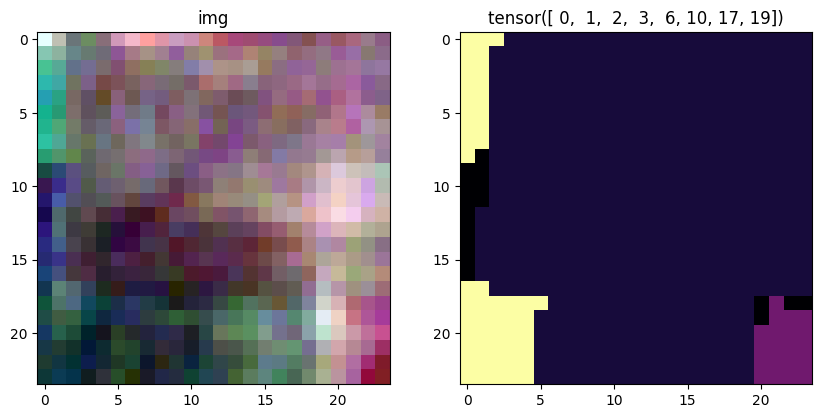

In [9]:
img, label = next(iter(dataset))

fix, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(get_rgb(img[0][:,:-1,:,:].numpy()))
axes[1].imshow(label[0].numpy(), cmap='inferno')

axes[0].set_title('img')
axes[1].set_title(f'{label.unique()}')

# Model

### Torch Vision Encoder

In [ ]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = input + self.pos_embedding
        return self.ln(self.layers(self.dropout(input)))

### DeepSat Encoder

In [10]:
import torch
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class PreNormLocal(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)
        # print('before fn: ', x.shape)
        x = self.fn(x, **kwargs)
        # print('after fn: ', x.shape)
        return x


class Conv1x1Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, kernel_size=1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(hidden_dim, dim, kernel_size=1),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # print(x.shape)
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # print(q.shape, k.shape, v.shape)
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class ReAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class LeFF(nn.Module):

    def __init__(self, dim=192, scale=4, depth_kernel=3):
        super().__init__()

        scale_dim = dim * scale
        self.up_proj = nn.Sequential(nn.Linear(dim, scale_dim),
                                     Rearrange('b n c -> b c n'),
                                     nn.BatchNorm1d(scale_dim),
                                     nn.GELU(),
                                     Rearrange('b c (h w) -> b c h w', h=14, w=14)
                                     )

        self.depth_conv = nn.Sequential(
            nn.Conv2d(scale_dim, scale_dim, kernel_size=depth_kernel, padding=1, groups=scale_dim, bias=False),
            nn.BatchNorm2d(scale_dim),
            nn.GELU(),
            Rearrange('b c h w -> b (h w) c', h=14, w=14)
            )

        self.down_proj = nn.Sequential(nn.Linear(scale_dim, dim),
                                       Rearrange('b n c -> b c n'),
                                       nn.BatchNorm1d(dim),
                                       nn.GELU(),
                                       Rearrange('b c n -> b n c')
                                       )

    def forward(self, x):
        x = self.up_proj(x)
        x = self.depth_conv(x)
        x = self.down_proj(x)
        return x


class LCAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        q = q[:, :, -1, :].unsqueeze(2)  # Only Lth element use as query

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out




class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

### Network

In [11]:
class Segmentation(nn.Module):
    def __init__(self, img_height=24, img_width=24, in_channel=10,
                       patch_size=3, embed_dim=128, max_time=60,
                       num_classes=20, num_head=4, dim_feedforward=2048,
                       num_layers=4
                ):
        super().__init__()
        
        self.H = img_height
        self.W = img_width
        self.P = patch_size
        self.C = in_channel
        self.d = embed_dim
        self.T = max_time
        self.K = num_classes

        self.d_model = self.d
        self.num_head = num_head
        self.dim_feedforward = self.d
        self.num_layers = num_layers

        self.N = int(self.H * self.W // self.P**2)
        self.nh = int(self.H / self.P)
        self.nw = int(self.W / self.P)




        '''
        PARAMETERS
        '''
        # Transformer Encoder
        # self.encoderLayer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.num_head, dim_feedforward=self.dim_feedforward)
        # self.encoder = nn.TransformerEncoder(self.encoderLayer, num_layers=self.num_layers)




        self.encoder = Transformer(self.d, self.num_layers, self.num_head, 32, self.d*4)







        # Patches
        self.projection = nn.Conv3d(self.C, self.d, kernel_size=(1, self.P, self.P), stride=(1, self.P, self.P))
        '''
        def __init__():
            self.linear = nn.Linear(self.C*self.P**2, self.d)
        def forward():
            x = x.view(B, T, H // P, W // P, C*P**2)
            x = self.linear(x)
        '''

        # Temporal
        self.temporal_emb = nn.Linear(366, self.d)
        self.temporal_cls_token = nn.Parameter(torch.randn(1, self.N, self.K, self.d)) # (N, K, d)
        self.temporal_transformer = self.encoder

        # Spatial
        self.spatial_emb = nn.Parameter(torch.randn(1, self.N, self.d)) # (1, N, d)
        # self.spatial_cls_token = nn.Parameter(torch.randn(1, self.K, self.d)) # (1, K, d)
        self.spatial_transformer = self.encoder

        # Segmentation Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.d),
            nn.Linear(self.d, self.P**2)
            )



    def forward(self, x):
        '''
        Tekenization

        Convert the images to a sequence of patches
        '''
        x_sits = x[:, :, :-1, :, :] # (B, T, C, H, W) -- > Exclude DOY Channel
        B, T, C, H, W = x_sits.shape # (B, T, C, H, W)
        x_sits = x_sits.reshape(B, C, T, H, W) # (B, C, T, H, W)
        x_sits = self.projection(x_sits) # (B, d, T, nw, nh)
        x_sits = x_sits.reshape(B, self.d, T, self.nh*self.nw) # (B, d, T, N)
        # x_sits = x_sits + self.pos_emb # (B, d, T, N)  we dont add pos embedding here, cuz we need the pure data for the temporal encoder
        x_sits = x_sits.permute(0,3,2,1) # (B, N, T, d)



        '''
        Temporal Encoding

        (DOY -> One-Hot -> Projection)
        '''
        xt = x[:, :, -1, 0, 0] # (B, T, C, H, W) in the last channel lies the DOY feature
        xt = F.one_hot(xt.to(torch.int64), num_classes=366).to(torch.float32) # (B, T, 366)
        Pt = self.temporal_emb(xt) # (B, T, d) (DOY, one-hot encoded to represent the DOY feature and then encoded to d dimensions)




        '''
        Temporal Encoder: cat(Z+Pt)

        add temporal embeddings (N*K) to the Time Series patches (T)
        '''
        x = x_sits + Pt.unsqueeze(1) # (B, N, T, d)
        temporal_cls_token = self.temporal_cls_token # (1, N, K, d)
        temporal_cls_token = temporal_cls_token.repeat(B, 1, 1, 1) # (B, N, K, d)
        temporal_cls_token = temporal_cls_token.reshape(B*self.N, self.K, self.d) # (B*N, K, d)
        x = x.reshape(B*self.N, T, self.d) # (B*N, T, d)
        # Temporal Tokens (N*K)
        x = torch.cat([temporal_cls_token, x], dim=1) # (B*N, K+T, d)
        # Temporal Transformer
        x = self.temporal_transformer(x) # (B*N, K+T, d)
        x = x.reshape(B, self.N, self.K + T, self.d) # (B, N, K+T, d)
        x = x[:,:,:self.K,:] # (B, N, K, d)
        x = x.permute(0, 2, 1, 3) # (B, K, N, d)
        x = x.reshape(B*(self.K), self.N, self.d) # (B*K, N, d)




        '''
        Spatial Encoding
        '''
        Ps = self.spatial_emb # (1, N, d)
        x = x + Ps # (B*K, N, d)
        '''
        # For Classification Only
        # spatial_cls_token = self.spatial_cls_token # (1, K, d)
        # spatial_cls_token = spatial_cls_token.unsqueeze(2) # (1, K, 1, d)
        # spatial_cls_token = spatial_cls_token.repeat(B, 1, 1, 1) # (B, K, 1, d)
        # x = torch.cat([spatial_cls_token, x], dim=2) # (B, K, 1+N, d)
        '''
        x = self.spatial_transformer(x) # (B*K, N, d)
        x = x.reshape(B, self.K, self.N, self.d) # (B, K, N, d)
        x = x.permute(0, 2, 1, 3) # (B, N, K, d)


        '''
        Segmentation Head
        '''
        # classes = x[:,:,0,:] # (B, K, d)
        # x = x[:,:,1:,:] # (B, K, N, d)
        
        x = self.mlp_head(x) # (B, N, K, P*P)


        '''
        Reassemble
        '''
        x = x.permute(0, 2, 3, 1) # (B, N, P*P, K)
        x = x.reshape(B, self.N, self.P, self.P, self.K) # (B, N, P, P, K)
        x = x.reshape(B, self.H, self.W, self.K) # (B, H, W, K)
        # x = x.permute(0, 3, 1, 2) # (B, K, H, W)


        return x

# Training

### Loss Function

In [12]:
class MaskedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, mean=True):
        super(MaskedCrossEntropyLoss, self).__init__()
        self.mean = mean
    
    def forward(self, logits, ground_truth):
        if type(ground_truth) == torch.Tensor:
            target = ground_truth
            mask = None
        elif len(ground_truth) == 1:
            target = ground_truth[0]
            mask = None
        elif len(ground_truth) == 2:
            target, mask = ground_truth
        else:
            raise ValueError("ground_truth parameter for MaskedCrossEntropyLoss is either (target, mask) or (target)")
        
        if mask is not None:
            mask_flat = mask.reshape(-1, 1)  # (N*H*W x 1)
            nclasses = logits.shape[-1]
            logits_flat = logits.reshape(-1, logits.size(-1))  # (N*H*W x Nclasses)
            masked_logits_flat = logits_flat[mask_flat.repeat(1, nclasses)].view(-1, nclasses)
            target_flat = target.reshape(-1, 1)  # (N*H*W x 1)
            masked_target_flat = target_flat[mask_flat].unsqueeze(dim=-1).to(torch.int64)
        else:
            masked_logits_flat = logits.reshape(-1, logits.size(-1))  # (N*H*W x Nclasses)
            masked_target_flat = target.reshape(-1, 1).to(torch.int64)  # (N*H*W x 1)
        masked_log_probs_flat = torch.nn.functional.log_softmax(masked_logits_flat, dim=1)  # (N*H*W x Nclasses)
        masked_losses_flat = -torch.gather(masked_log_probs_flat, dim=1, index=masked_target_flat)  # (N*H*W x 1)
        if self.mean:
            return masked_losses_flat.mean()
        return masked_losses_flat

### Train

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data
batch_size = 2
dataset = DataLoader(data, batch_size=batch_size, shuffle=True)
num_samples = dataset.__len__()*batch_size

# Model
model = Segmentation(img_width=24, img_height=24, in_channel=10, patch_size=3, embed_dim=128, max_time=60, num_head=8, num_layers=8, num_classes=20)
model.to(device)

num_params = sum([p.numel() for p in model.parameters() if p.requires_grad == True])
print('Number of Parameters: ', num_params)

# Loss
criterion = MaskedCrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
epochs = 100
model.train()

Number of Parameters:  2339721


Segmentation(
  (encoder): Transformer(
    (layers): ModuleList(
      (0-7): 8 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=512, out_features=128, bias=True)
              (4): Dropout(p=0.0, inplace=False)
            )
          )
        )
      )
    )
    (norm): LayerNorm((128,

### Trainer

In [14]:
from tqdm import tqdm
for epoch in range(epochs):
  epoch_loss = 0

  t1 = time.time()
  for batch in tqdm(dataset):
    img, label = batch
    img, label = img.to(device), label.to(device)


    optimizer.zero_grad()
    
    output = model(img)
    
    # print(f'Output shape: {output.shape} | Label shape: {label.shape}')
    # print('Output: ', output[0], 'Label: ', label[0])

    loss = criterion(output, label)
    epoch_loss += loss

    loss.backward()
    optimizer.step()


  if epoch % 10 == 0:
    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, f'./weights/epoch_{epoch}.pt')
  t2 = time.time()
  print('Epoch: ', epoch, 'Loss: ', (epoch_loss/num_samples)*100)

100%|██████████| 250/250 [00:25<00:00,  9.88it/s]


Epoch:  0 Loss:  tensor(129.8928, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.08it/s]


Epoch:  1 Loss:  tensor(112.4386, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.03it/s]


Epoch:  2 Loss:  tensor(109.8572, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:25<00:00,  9.99it/s]


Epoch:  3 Loss:  tensor(107.8857, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:25<00:00,  9.98it/s]


Epoch:  4 Loss:  tensor(105.8001, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.01it/s]


Epoch:  5 Loss:  tensor(105.8053, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.04it/s]


Epoch:  6 Loss:  tensor(104.7655, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.05it/s]


Epoch:  7 Loss:  tensor(103.0245, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.07it/s]


Epoch:  8 Loss:  tensor(101.7697, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.08it/s]


Epoch:  9 Loss:  tensor(100.5096, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.08it/s]


Epoch:  10 Loss:  tensor(100.3528, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.09it/s]


Epoch:  11 Loss:  tensor(98.3200, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.10it/s]


Epoch:  12 Loss:  tensor(97.5872, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.10it/s]


Epoch:  13 Loss:  tensor(96.1902, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.10it/s]


Epoch:  14 Loss:  tensor(94.6718, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.06it/s]


Epoch:  15 Loss:  tensor(94.7932, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:24<00:00, 10.03it/s]


Epoch:  16 Loss:  tensor(93.4093, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 250/250 [00:25<00:00,  9.99it/s]


Epoch:  17 Loss:  tensor(90.9597, device='cuda:0', grad_fn=<MulBackward0>)


 36%|███▋      | 91/250 [00:09<00:15,  9.94it/s]


KeyboardInterrupt: 